<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Breast cancer detection with XGBoost and IBM Watson Machine Learning</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/pmservice/wml-sample-notebooks/master/images/cancer_banner-06.png" alt="Icon" width="700"> </th>
   </tr>
</table>

This notebook contains steps and code to get data from the IBM Watson Data Platform Community, create a predictive model, and start scoring new data. This notebook introduces commands for getting and exploration data, model training. We show how to model persist model to repository, deployment and score using Watson Machine Learning service.

Some familiarity with Python is helpful. This notebook uses Python 3.5, XGBoost and scikit-learn.

You will use a publicly available data set, Breast Cancer Wisconsin (Diagnostic) Data Set to train XGBoost Model, which is short for “Extreme Gradient Boosting”, to classify breast cancer tumors (as benign or malignant) from 569 diagnostic images based on measurements such as radius, texture, perimeter and area.

## Learning goals

The learning goals of this notebook are:

-  Load a CSV file into numpy array.
-  Explore data.
-  Prepare data for training and evaluation.
-  Create an XGBoost machine learning model.
-  Train and evaluate a model.
-  Use cross-validation to optimize model's hyperparameters.
-  Persist a model in Watson Machine Learning repository.
-  Deploy a model for online scoring.
-  Score sample data.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Load and explore data](#load)
3.	[Create XGBoost model](#model)
4.	[Persist model](#persistence)
5.	[Deploy and score in a Cloud](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you have to perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered). 
-  Download **Breast Cancer Wisconsin (Diagnostic) Data Set** dataset from IBM Watson Data Platform. We provide code to download dataset below.

**Note:** The Breast Cancer Wisconsin (Diagnostic) Data Set is a freely available data set on the Watson Data Platform Community [page](https://dataplatform.ibm.com/community?context=analytics).

<a id="load"></a>
## 2. Load and explore data

In this section you will load the data as numpy array and perform a basic exploration.

Load the data to the numpy array by using `wget` to download the data to gpfs and then read data using `genfromtxt` method. 

**Example**: First, you need to install required packages. You can do it by running the following code. Run it only one time.<BR><BR>

In [1]:
!pip install wget --user --upgrade

Requirement already up-to-date: wget in /home/dsxuser/.local/lib/python3.5/site-packages


In [2]:
import wget, os

WisconsinDataSet = 'BreastCancerWisconsinDataSet.csv' 
if not os.path.isfile(WisconsinDataSet):
    link_to_data = 'https://apsportal.ibm.com/exchange-api/v1/entries/c173693bf48aeb22e41bbe2b41d79c1f/data?accessKey=941eec501eadcdceb5abd25cf7c029d5'
    WisconsinDataSet = wget.download(link_to_data)

print(WisconsinDataSet)

BreastCancerWisconsinDataSet.csv


The csv file **BreastCancerWisconsinDataSet.csv** is availble on gpfs now. Load the file to numpy array using code below.

In [3]:
!pip install numpy --user --upgrade

    100% |████████████████████████████████| 12.1MB 70kB/s  eta 0:00:01


In [4]:
import numpy as np

np_data = np.genfromtxt(WisconsinDataSet, delimiter=',', names=True, dtype=None, encoding='utf-8')

In [5]:
np_data[:3]

array([(  842302, 'M', 17.99, 10.38, 122.8, 1001., 0.1184 , 0.2776 , 0.3001, 0.1471 , 0.2419, 0.07871, 1.095 , 0.9053, 8.589, 153.4 , 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019., 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189 ),
       (  842517, 'M', 20.57, 17.77, 132.9, 1326., 0.08474, 0.07864, 0.0869, 0.07017, 0.1812, 0.05667, 0.5435, 0.7339, 3.398,  74.08, 0.005225, 0.01308, 0.0186 , 0.0134 , 0.01389, 0.003532, 24.99, 23.41, 158.8, 1956., 0.1238, 0.1866, 0.2416, 0.186 , 0.275 , 0.08902),
       (84300903, 'M', 19.69, 21.25, 130. , 1203., 0.1096 , 0.1599 , 0.1974, 0.1279 , 0.2069, 0.05999, 0.7456, 0.7869, 4.585,  94.03, 0.00615 , 0.04006, 0.03832, 0.02058, 0.0225 , 0.004571, 23.57, 25.53, 152.5, 1709., 0.1444, 0.4245, 0.4504, 0.243 , 0.3613, 0.08758)],
      dtype=[('id', '<i8'), ('diagnosis', '<U1'), ('radius_mean', '<f8'), ('texture_mean', '<f8'), ('perimeter_mean', '<f8'), ('area_mean', '<f8'), ('smoothness_mean', '<f8'), ('compactness_mean'

In [6]:
print('Number of rows: {}'.format(np_data.size))
print('Number of columns: {}'.format(len(np_data[0])))

Number of rows: 569
Number of columns: 32


We can see that dataset has 569 records and 32 features.

We can generate basic information about features in our dataset.

In [7]:
for i, col in enumerate(list(np_data.dtype.names)):
    print('{:2d}. {}: {}'.format(i, col, np_data.dtype.fields[col][0]))

 0. id: int64
 1. diagnosis: <U1
 2. radius_mean: float64
 3. texture_mean: float64
 4. perimeter_mean: float64
 5. area_mean: float64
 6. smoothness_mean: float64
 7. compactness_mean: float64
 8. concavity_mean: float64
 9. concave_points_mean: float64
10. symmetry_mean: float64
11. fractal_dimension_mean: float64
12. radius_se: float64
13. texture_se: float64
14. perimeter_se: float64
15. area_se: float64
16. smoothness_se: float64
17. compactness_se: float64
18. concavity_se: float64
19. concave_points_se: float64
20. symmetry_se: float64
21. fractal_dimension_se: float64
22. radius_worst: float64
23. texture_worst: float64
24. perimeter_worst: float64
25. area_worst: float64
26. smoothness_worst: float64
27. compactness_worst: float64
28. concavity_worst: float64
29. concave_points_worst: float64
30. symmetry_worst: float64
31. fractal_dimension_worst: float64


<a id="model"></a>
## 3. Create XGBoost model

In recent years, ensemble learning models took the lead and became popular among machine learning practitioners.

XGBoost classifier makes its predictions based on the majority vote from collection of models which are a set of classification trees. It uses the combination of weak learners to create single strong learner. It’s a sequential training process, new learners focus on the misclassified examples of previous learners.

XGBoost is an open source library for ensemble based algorithms.

In this section you will learn how to train and test a XGBoost model.

### 3.1: Prepare data

After looking at description of features in our dataset, we can prepare our data for model building. We will use "diagnosis" columns as our target variable and remove id variable from set of predictors.

In [8]:
y = 1.0*(np_data['diagnosis'] == 'M')
X = np.array([list(r)[2:] for r in np_data])

We split the dataset into: train and test datasets.

In [9]:
from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
print("Number of training records: " + str(X_train.shape[0]))
print("Number of testing records : " + str(X_test.shape[0]))

Number of training records: 369
Number of testing records : 200


As you can see our data has been successfully split into two datasets:
- The train data set, which is the largest group, is used for training.
- The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 3.2: Create XGBoost model

We start with importing necessary libraries.

In [11]:
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 3.2.1: Model with default hyperparameters

In this section we create XGBoost classifier with default values for hyperparameters. In next sections we will show how to improve this model base model.

In [12]:
xgb_model = XGBClassifier()

We can see the default parameters of the model.

In [13]:
xgb_model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Once we have our XGBoost classifier is set up, we can train it by invoking fit method. We will also evaluate model during training process on train and test data.

In [14]:
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.02168	validation_1-error:0.05
[1]	validation_0-error:0.01897	validation_1-error:0.05
[2]	validation_0-error:0.01897	validation_1-error:0.05
[3]	validation_0-error:0.01897	validation_1-error:0.05
[4]	validation_0-error:0.01897	validation_1-error:0.05
[5]	validation_0-error:0.01897	validation_1-error:0.05
[6]	validation_0-error:0.01897	validation_1-error:0.05
[7]	validation_0-error:0.01626	validation_1-error:0.05
[8]	validation_0-error:0.01355	validation_1-error:0.05
[9]	validation_0-error:0.01084	validation_1-error:0.05
[10]	validation_0-error:0.01084	validation_1-error:0.05
[11]	validation_0-error:0.01084	validation_1-error:0.05
[12]	validation_0-error:0.01084	validation_1-error:0.05
[13]	validation_0-error:0.01084	validation_1-error:0.05
[14]	validation_0-error:0.01084	validation_1-error:0.05
[15]	validation_0-error:0.00813	validation_1-error:0.05
[16]	validation_0-error:0.01084	validation_1-error:0.05
[17]	validation_0-error:0.01084	validation_1-error:0.04
[1

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

We plot the model performance evaluated during training process to assess model overfitting.

In [15]:
from matplotlib import pyplot

%matplotlib inline

Text(0.5,0,'Number of iterations')

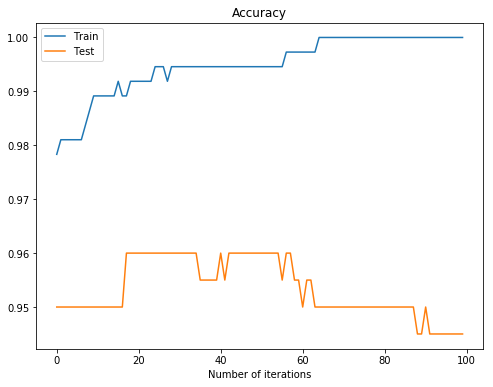

In [19]:
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = pyplot.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

We can see that there is model overfitting. We see some model accuracy deacrease after about 60 iterations.

We select model trained after 30 iterations.

In [20]:
n_trees = 30
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 96.0%


**Note:** We see that model accuracy on test set. We will use accuracy on test data to compare with model selected using parameter tuning.

### 3.2.1: Grid search for best model over hyperparameter space

We can tune our model now to achieve better accuracy by using grid search and cross validation.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape algorithm’s desired behavior. Here we will tune model optimizing which adds L1 penalty (`reg_alpha`).
We will use 10 fold crossvalidation because our training dataset is small.

In cell below, we create our XGBoost pipeline and setup parameter grid for search.

In [22]:
xgb_model_gs = XGBClassifier()
parameters = {'reg_alpha': [0.0, 1.0], 'reg_lambda': [0.0, 1.0], 'n_estimators': [n_trees], 'seed': [1337]}

We can search for the best parameters over specified parameters values above with GridSearchCV.

In [23]:
clf = GridSearchCV(xgb_model_gs, parameters, scoring='accuracy', cv=10, verbose=0, refit=True)
clf.fit(X_train, y_train)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'seed': [1337], 'n_estimators': [30], 'reg_lambda': [0.0, 1.0], 'reg_alpha': [0.0, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

We can see the performance result of all parameter combinations including the best parameter combination based on model performance from grid search scores

In [24]:
clf.grid_scores_

[mean: 0.94851, std: 0.03689, params: {'seed': 1337, 'n_estimators': 30, 'reg_lambda': 0.0, 'reg_alpha': 0.0},
 mean: 0.95393, std: 0.03813, params: {'seed': 1337, 'n_estimators': 30, 'reg_lambda': 1.0, 'reg_alpha': 0.0},
 mean: 0.95664, std: 0.03834, params: {'seed': 1337, 'n_estimators': 30, 'reg_lambda': 0.0, 'reg_alpha': 1.0},
 mean: 0.95393, std: 0.03616, params: {'seed': 1337, 'n_estimators': 30, 'reg_lambda': 1.0, 'reg_alpha': 1.0}]

Accuracy estimated using crossvalidation and hyperparameter values for best model.

In [25]:
print("Best score: %.1f%%" % (clf.best_score_*100))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 95.7%
Best parameter set: {'seed': 1337, 'n_estimators': 30, 'reg_lambda': 0.0, 'reg_alpha': 1.0}


We can see the accuracy of best parameter combination on test set.

In [26]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 96.0%


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We see that accuracy on test set is about the same for tuned model as for trained with default values for hyperparameters. Altghough selected hyperparameters are different then default.

### 3.2.3: Model with pipeline data preprocessing

Here you will see how to use XGBoost model within scikit-learn pipeline. 
Let's start with importing required objects.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=10)
xgb_model_pca = XGBClassifier(n_estimators=n_trees)
pipeline = Pipeline(steps=[('pca', pca), ('xgb', xgb_model_pca)])

In [29]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=30, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

Now we are ready to evaluate accurracy of model trained on reduced set of features.

In [30]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 95.5%


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We can see that model has similar accuracy to trained using default hyperparameter values.

Let's see how we can save our XGBoost pipeline using Watson Machine Learning instance and deploy it for online scoring.

<a id="persistence"></a>
## 4. Persist model

In this section you will learn how to store your XGBoost model in Watson Machine Learning repository by using python client libraries.

First, you must import client libraries.

In [31]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [32]:
!pip install watson-machine-learning-client --upgrade --user

    100% |████████████████████████████████| 563kB 1.7MB/s eta 0:00:01
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: lomond in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-

In [33]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Authenticate to Watson Machine Learning service on IBM Cloud.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.</div>

In [34]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

In [35]:
# The code was removed by DSX for sharing.

**Tip**: Service Credentials can be found on service dashboard on IBM Cloud.

In [36]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 4.1: Save a XGBoost model in the ML Repository

In this subsection you will learn how to save model artifact to your Watson Machine Learning instance.

In [37]:
model_props = {client.repository.ModelMetaNames.NAME: "XGBoost model for breast cancer"}
model_details = client.repository.store_model(pipeline, model_props)

Get saved model metadata from Watson Machine Learning.

# 5. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the Watson Machine Learning.

You can list all stored models using method `list_models`.

In [38]:
client.repository.list_models()

------------------------------------  -------------------------------  ------------------------  -----------------
GUID                                  NAME                             CREATED                   FRAMEWORK
6b76f1d7-aff2-445d-b816-0c4c573fbf7d  Product Line Prediction          2018-02-18T19:51:57.776Z  mllib-2.0
4b7c9d27-6ca3-4b89-b726-9dd32ccb3958  Tumor_Type_Detection_v1_pipe     2018-03-18T23:37:40.678Z  scikit-learn-0.19
7c60098c-5c16-47f8-89e6-f72a629a9bff  My cool mnist model              2018-03-19T09:42:42.204Z  tensorflow-1.5
5999a2d9-e22c-424e-839f-d1f9c37ba8c0  XGBoost model for breast cancer  2018-03-29T14:00:39.597Z  scikit-learn-0.19
bc1104f5-9bba-4bf4-a8cc-34eff218ae4a  XGBoost model for breast cancer  2018-04-03T10:05:17.385Z  scikit-learn-0.19
------------------------------------  -------------------------------  ------------------------  -----------------


We use model uid to create deployment. We can extract it from saved model details.

In [39]:
model_uid = client.repository.get_model_uid(model_details)
print(model_uid)

bc1104f5-9bba-4bf4-a8cc-34eff218ae4a


### 5.1: Create model deployment

Now you can create a deployment.

In [40]:
deployment_details = client.deployments.create(model_uid, 'Predict breast cancer')



#######################################################################################

Synchronous deployment creation for uid: 'e63d45ac-c27d-4002-8795-81d16ea98f6d' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e63d45ac-c27d-4002-8795-81d16ea98f6d'
------------------------------------------------------------------------------------------------




Get the list of deployments.

In [41]:
client.deployments.list()

------------------------------------  ----------------------  ------  --------------  ------------------------  -----------------
GUID                                  NAME                    TYPE    STATE           CREATED                   FRAMEWORK
0e4ad207-9c30-4157-a55f-ac83808c9a2b  Predict breast cancer   online  DEPLOY_SUCCESS  2018-03-29T14:00:52.650Z  scikit-learn-0.19
206ce253-eaaa-40f0-9aac-bc0d25e3fe88  online                  online  DEPLOY_SUCCESS  2018-02-18T19:52:22.583Z  mllib-2.0
40f24853-f991-4aa1-9936-830f197aa758  Mnist model deployment  online  DEPLOY_SUCCESS  2018-03-19T09:42:58.735Z  tensorflow-1.5
65e272bc-ff7e-4136-b210-c7a1a831a7f8  skl_xgb_cancer1_pipe    online  DEPLOY_SUCCESS  2018-03-18T23:38:07.407Z  scikit-learn-0.19
e63d45ac-c27d-4002-8795-81d16ea98f6d  Predict breast cancer   online  DEPLOY_SUCCESS  2018-04-03T10:06:50.606Z  scikit-learn-0.19
------------------------------------  ----------------------  ------  --------------  -----------------------

### 5. 3 Perform Prediction

Now, you have extract url endpoint used to send scoring requests.

In [42]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/37c88e6f-2a51-43f8-be5a-17a928580075/published_models/bc1104f5-9bba-4bf4-a8cc-34eff218ae4a/deployments/e63d45ac-c27d-4002-8795-81d16ea98f6d/online


Prepare scoring payload with values to score.

In [43]:
payload_scoring = {"values": [X_test[0].tolist()]}
print(payload_scoring)

{'values': [[12.23, 19.56, 78.54, 461.0, 0.09586, 0.08087, 0.04187, 0.04107, 0.1979, 0.06013, 0.3534, 1.326, 2.308, 27.24, 0.007514, 0.01779, 0.01401, 0.0114, 0.01503, 0.003338, 14.44, 28.36, 92.15, 638.4, 0.1429, 0.2042, 0.1377, 0.108, 0.2668, 0.08174]]}


In [44]:
response_scoring = client.deployments.score(scoring_url, payload_scoring)
print(response_scoring)

{'fields': ['prediction', 'probability'], 'values': [[0.0, [0.9505169987678528, 0.04948299005627632]]]}


As we can see, given patient record is classified as benign tumor.

<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! You learned how to use XGBoost machine learning as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://console.bluemix.net/docs/services/PredictiveModeling/index.html#WMLgettingstarted)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

Wojciech Sobala is Data Scientist at IBM.

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.